<a href="https://colab.research.google.com/github/JaperTai77/Tensorflow_DL/blob/main/tf2_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision 101

## Preparation

#### Import package and data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
(trainset, testset), info = tfds.load(name = 'food101',
                                split = ['train', 'validation'],
                                shuffle_files = True,
                                as_supervised = True, # return data and label
                                with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePD3Q2N/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePD3Q2N/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
class_name = info.features['label'].names

#### Explore dataset

In [8]:
one_sample = trainset.take(1)
for im, lab in one_sample:
  print(im.shape)
  print(im.dtype)
  print(lab)

(512, 512, 3)
<dtype: 'uint8'>
tf.Tensor(21, shape=(), dtype=int64)


In [9]:
tf.reduce_min(im), tf.reduce_max(im)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

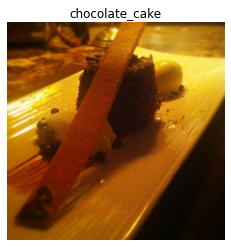

In [10]:
plt.imshow(im)
plt.title(class_name[lab.numpy()])
plt.axis(False)

## Preprocessing

#### Convert shape, data type, and resize

https://www.tensorflow.org/guide/data_performance

Here is a summary of the best practices for designing performant TensorFlow input pipelines:

Use the **prefetch** transformation to overlap the work of a producer and consumer\
Parallelize the data reading transformation using the **interleave** transformation\
Parallelize the **map** transformation by setting the **num_parallel_calls** argument\
Use the **cache** transformation to cache data in memory during the first epoch\
Vectorize user-defined functions passed in to the **map** transformation\
Reduce memory usage when applying the **interleave**, **prefetch**, and **shuffle** transformations

In [11]:
def preprocessing(image,label,imgShape = 224):
  image = tf.image.resize(image,size = [imgShape,imgShape])
  image = tf.cast(image,tf.float32)
  # image = image/255. no need for efficientNet
  return image, label

In [14]:
train = trainset.map(map_func = preprocessing,
          num_parallel_calls = tf.data.AUTOTUNE) 
# utilize all computing power
test = testset.map(map_func = preprocessing,
          num_parallel_calls = tf.data.AUTOTUNE) 

#### Shuffle and batch

In [15]:
train = train.shuffle(buffer_size = 1000) 
# how many data to shuffle at a time
train = train.batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)

test = test.batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)#.cache() store in RAM

## Build Model

#### Callbacks

In [16]:
# tensorboard
tensorboard = tf.keras.callbacks.TensorBoard('traininglogs/efficientnetb0_101_classes_all_data_feature_extract')

# checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/cp.ckpt',
                                                monitor = 'val_acc',
                                                save_best_only = True,
                                                save_weights_only = True,
                                                verbose = 0)

#### Mixed precision training

In [17]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

mixed_precision.global_policy() # should output "mixed_float16"

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


<Policy "mixed_float16">

#### Feature extraction model

In [18]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
input = tf.keras.layers.Input(shape = (224,224,3),name = 'input')
x = base_model(input,training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = tf.keras.layers.Dense(len(class_name))(x)
# Activation function need to be in float32 when using mixed precision training
output = tf.keras.layers.Activation('softmax',dtype = tf.float32)(x)
model = tf.keras.Model(input,output)

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainabl

In [ ]:
for layer in model.layers:
  print(layer.name, layer.dtype_policy)

input <Policy "float32">
efficientnetb0 <Policy "mixed_float16">
pooling_layer <Policy "mixed_float16">
dense <Policy "mixed_float16">
activation <Policy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.dtype_policy)

input_1 <Policy "float32">
rescaling <Policy "mixed_float16">
normalization <Policy "mixed_float16">
stem_conv_pad <Policy "mixed_float16">
stem_conv <Policy "mixed_float16">
stem_bn <Policy "mixed_float16">
stem_activation <Policy "mixed_float16">
block1a_dwconv <Policy "mixed_float16">
block1a_bn <Policy "mixed_float16">
block1a_activation <Policy "mixed_float16">
block1a_se_squeeze <Policy "mixed_float16">
block1a_se_reshape <Policy "mixed_float16">
block1a_se_reduce <Policy "mixed_float16">
block1a_se_expand <Policy "mixed_float16">
block1a_se_excite <Policy "mixed_float16">
block1a_project_conv <Policy "mixed_float16">
block1a_project_bn <Policy "mixed_float16">
block2a_expand_conv <Policy "mixed_float16">
block2a_expand_bn <Policy "mixed_float16">
block2a_expand_activation <Policy "mixed_float16">
block2a_dwconv_pad <Policy "mixed_float16">
block2a_dwconv <Policy "mixed_float16">
block2a_bn <Policy "mixed_float16">
block2a_activation <Policy "mixed_float16">
block2a_se_squeeze <P

In [19]:
train

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [20]:
test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [21]:
history = model.fit(train, epochs = 3,
                    steps_per_epoch = len(train),
                    validation_data = test,
                    validation_steps = int(0.10*len(test)),
                    callbacks = [checkpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8215 - accuracy: 0.5562WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 301s 108ms/step - loss: 1.8215 - accuracy: 0.5562 - val_loss: 1.2182 - val_accuracy: 0.6721
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2938 - accuracy: 0.6651WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 244s 102ms/step - loss: 1.2939 - accuracy: 0.6651 - val_loss: 1.1279 - val_accuracy: 0.6998
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1427 - accuracy: 0.7034WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 246s 103ms/step - loss: 1.1428 - accuracy: 0.7034 - val_loss: 1.0740 - val_accuracy: 0.7081


In [22]:
model.evaluate(test)

790/790 [==============================] - 81s 103ms/step - loss: 1.0892 - accuracy: 0.7045


[1.08920156955719, 0.7045148611068726]

#### Clone model

In [ ]:
clone_model = tf.keras.models.clone_model(model)
clone_model.load_weights('model_checkpoints/cp.ckpt')

In [ ]:
# save to drive
model.save('drive/MyDrive/tf2/food101_model')
model = tf.keras.models.load_model('drive/MyDrive/tf2/food101_model')

## Fine Tune Model

#### More callbacks

In [25]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              patience = 3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('finetuneCheckpoint',
                                                save_best_only = True,
                                                monitor = 'val_loss')
# learning rate reduction callback
red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.2, # multiply learning rate by 0.2 (1/5))
                                              patience = 2, verbose = 1,
                                              min_lr = 1e-7 # set a minimum learning rate
                                              )

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])
history_tuned = model.fit(train,epochs = 100,
                          steps_per_epoch = len(train),
                          validation_data = test,
                          validation_steps = int(0.10*len(test)),
                          callbacks = [earlystop,checkpoint,red_lr])

Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9722 - accuracy: 0.7509INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 318s 130ms/step - loss: 0.9722 - accuracy: 0.7509 - val_loss: 1.0473 - val_accuracy: 0.7176 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9550 - accuracy: 0.7564INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 306s 128ms/step - loss: 0.9549 - accuracy: 0.7564 - val_loss: 1.0457 - val_accuracy: 0.7231 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9439 - accuracy: 0.7599INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 303s 127ms/step - loss: 0.9438 - accuracy: 0.7599 - val_loss: 1.0404 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9342 - accuracy: 0.7623INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 309s 130ms/step - loss: 0.9343 - accuracy: 0.7623 - val_loss: 1.0397 - val_accuracy: 0.7243 - lr: 1.0000e-04
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9255 - accuracy: 0.7654INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 307s 129ms/step - loss: 0.9255 - accuracy: 0.7654 - val_loss: 1.0392 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - 249s 104ms/step - loss: 0.9171 - accuracy: 0.7672 - val_loss: 1.0400 - val_accuracy: 0.7215 - lr: 1.0000e-04
Epoch 7/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9091 - accuracy: 0.7694INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 308s 129ms/step - loss: 0.9091 - accuracy: 0.7694 - val_loss: 1.0309 - val_accuracy: 0.7235 - lr: 1.0000e-04
Epoch 8/100
2368/2368 [==============================] - 249s 104ms/step - loss: 0.9014 - accuracy: 0.7713 - val_loss: 1.0314 - val_accuracy: 0.7219 - lr: 1.0000e-04
Epoch 9/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8940 - accuracy: 0.7740INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 305s 128ms/step - loss: 0.8941 - accuracy: 0.7740 - val_loss: 1.0307 - val_accuracy: 0.7231 - lr: 1.0000e-04
Epoch 10/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8867 - accuracy: 0.7758INFO:tensorflow:Assets written to: finetuneCheckpoint/assets


INFO:tensorflow:Assets written to: finetuneCheckpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 304s 128ms/step - loss: 0.8866 - accuracy: 0.7758 - val_loss: 1.0271 - val_accuracy: 0.7239 - lr: 1.0000e-04
Epoch 11/100
2368/2368 [==============================] - 247s 103ms/step - loss: 0.8797 - accuracy: 0.7779 - val_loss: 1.0280 - val_accuracy: 0.7271 - lr: 1.0000e-04
Epoch 12/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8726 - accuracy: 0.7797
Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 247s 103ms/step - loss: 0.8726 - accuracy: 0.7797 - val_loss: 1.0326 - val_accuracy: 0.7231 - lr: 1.0000e-04
Epoch 13/100
2368/2368 [==============================] - 247s 103ms/step - loss: 0.8573 - accuracy: 0.7845 - val_loss: 1.0292 - val_accuracy: 0.7207 - lr: 2.0000e-05


In [28]:
model.evaluate(test)

790/790 [==============================] - 75s 94ms/step - loss: 1.0318 - accuracy: 0.7205


[1.031782627105713, 0.7205148339271545]

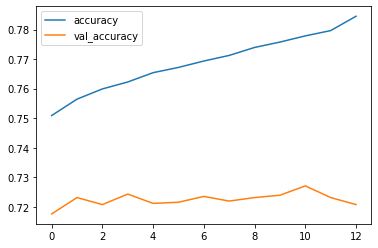

In [30]:
pd.DataFrame(history_tuned.history)[['accuracy','val_accuracy']].plot()